In [3]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt

from pathlib import Path
from clearml import Logger
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

from src import data_preprocessing as dp
from src import pipeline as pl
from src import new_feature_engineering_hourly as fe
from src import feature_selection as fs
from src.model_evaluation import evaluate, evaluate_multi_output
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


In [4]:
# 1. Load dữ liệu
df = dp.load_data("data/hourly_to_daily_weather.csv")

# 2. Giữ cột datetime trước khi preprocessing
df['datetime'] = pd.to_datetime(df['datetime'])

# 3. Chạy preprocessing nhưng không đổi cột datetime
df = dp.basic_preprocessing_hourly(df=df)

# 4. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

train_df.columns

 Loaded data with shape: (3654, 62)
--- Starting column dropping process ---
Column not found: 'description', skipping.
Column not found: 'icon', skipping.
Column not found: 'stations', skipping.
Column not found: 'name', skipping.
Column not found: 'address', skipping.
Column not found: 'resolvedAddress', skipping.
Column not found: 'precipprob', skipping.
Column not found: 'preciptype', skipping.
Column not found: 'severerisk', skipping.
Column not found: 'source', skipping.
Column not found: 'snow', skipping.
Column not found: 'snowdepth', skipping.
Column not found: 'longitude', skipping.
Column not found: 'latitude', skipping.
--- Column dropping process finished ---


Index(['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'windgust', 'windspeed',
       'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'cond_6h_0', 'cond_6h_1',
       'cond_6h_2', 'cond_6h_3', 'temp_mean_6h_next0', 'temp_mean_6h_next1',
       'temp_mean_6h_next2', 'temp_mean_6h_next3', 'temp_max_6h_next0',
       'temp_max_6h_next1', 'temp_max_6h_next2', 'temp_max_6h_next3',
       'temp_min_6h_next0', 'temp_min_6h_next1', 'temp_min_6h_next2',
       'temp_min_6h_next3', 'feelslike_mean_6h_next0',
       'feelslike_mean_6h_next1', 'feelslike_mean_6h_next2',
       'feelslike_mean_6h_next3', 'feelslike_max_6h_next0',
       'feelslike_max_6h_next1', 'feelslike_max_6h_next2',
       'feelslike_max_6h_next3', 'feelslike_min_6h_next0',
       'feelslike_min_6h_next1', 'feelslike_min_6h_next2',
       'feelslike_min_6h_next3', 'dew_mean_6h_next0', 'dew_mean_6h_next1

In [5]:
# 1. Chia train, test theo thời gian (80/20)
train_size = 0.8
n = len(df)

train_df = df.iloc[:int(train_size * n)]
test_df = df.iloc[int(train_size * n):]

In [6]:
train_df.columns

Index(['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'windgust', 'windspeed',
       'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'cond_6h_0', 'cond_6h_1',
       'cond_6h_2', 'cond_6h_3', 'temp_mean_6h_next0', 'temp_mean_6h_next1',
       'temp_mean_6h_next2', 'temp_mean_6h_next3', 'temp_max_6h_next0',
       'temp_max_6h_next1', 'temp_max_6h_next2', 'temp_max_6h_next3',
       'temp_min_6h_next0', 'temp_min_6h_next1', 'temp_min_6h_next2',
       'temp_min_6h_next3', 'feelslike_mean_6h_next0',
       'feelslike_mean_6h_next1', 'feelslike_mean_6h_next2',
       'feelslike_mean_6h_next3', 'feelslike_max_6h_next0',
       'feelslike_max_6h_next1', 'feelslike_max_6h_next2',
       'feelslike_max_6h_next3', 'feelslike_min_6h_next0',
       'feelslike_min_6h_next1', 'feelslike_min_6h_next2',
       'feelslike_min_6h_next3', 'dew_mean_6h_next0', 'dew_mean_6h_next1

In [7]:

pd.set_option('display.max_rows', None)     # Hiện tất cả rows
pd.set_option('display.max_columns', None)  # Hiện tất cả cột
pd.set_option('display.width', None)        # Không giới hạn độ rộng
pd.set_option('display.max_colwidth', None) # Hiện đầy đủ nội dung cột


In [8]:

#4. Tạo feature engineering (drop NaN sau khi rolling/lag)
train_feat, target_col = fe.feature_engineering(train_df, is_drop_nan= False, is_drop_base= False)
test_feat, _ = fe.feature_engineering(test_df, is_drop_nan= False, is_drop_base= False)


Đã tạo tổng cộng 76 lag features.
Cảnh báo: Cột 'rain_intensity' không tồn tại trong DataFrame, bỏ qua.
Đã tạo 79 rolling features.
Đã tạo tổng cộng 76 lag features.
Cảnh báo: Cột 'rain_intensity' không tồn tại trong DataFrame, bỏ qua.
Đã tạo 79 rolling features.


In [9]:
from src import feature_selection as fs
for feat in train_feat.columns:
   print(feat)

temp
tempmax
tempmin
feelslikemax
feelslikemin
feelslike
dew
humidity
precip
windgust
windspeed
winddir
sealevelpressure
cloudcover
visibility
solarradiation
solarenergy
uvindex
cond_6h_0
cond_6h_1
cond_6h_2
cond_6h_3
temp_mean_6h_next0
temp_mean_6h_next1
temp_mean_6h_next2
temp_mean_6h_next3
temp_max_6h_next0
temp_max_6h_next1
temp_max_6h_next2
temp_max_6h_next3
temp_min_6h_next0
temp_min_6h_next1
temp_min_6h_next2
temp_min_6h_next3
feelslike_mean_6h_next0
feelslike_mean_6h_next1
feelslike_mean_6h_next2
feelslike_mean_6h_next3
feelslike_max_6h_next0
feelslike_max_6h_next1
feelslike_max_6h_next2
feelslike_max_6h_next3
feelslike_min_6h_next0
feelslike_min_6h_next1
feelslike_min_6h_next2
feelslike_min_6h_next3
dew_mean_6h_next0
dew_mean_6h_next1
dew_mean_6h_next2
dew_mean_6h_next3
dew_max_6h_next0
dew_max_6h_next1
dew_max_6h_next2
dew_max_6h_next3
dew_min_6h_next0
dew_min_6h_next1
dew_min_6h_next2
dew_min_6h_next3
solarradiation_max
solarenergy_max
uvindex_max
temp_next_1
temp_next_2
tem

In [10]:
print(train_feat.shape, test_feat.shape)

(2918, 290) (726, 290)


In [11]:
# Chia X, y riêng biệt
X_train = train_feat.drop(columns= target_col)
y_train = train_feat[target_col]

X_test = test_feat.drop(columns= target_col)
y_test = test_feat[target_col]

print(f"Train: {X_train.shape, y_train.shape}, Test: {X_test.shape, y_test.shape}")

Train: ((2918, 285), (2918, 5)), Test: ((726, 285), (726, 5))


In [12]:
# Task.current_task().close()

### LGB

In [13]:
# mỗi lần chạy xong, thì tạo task mới
# Tạo task mới trong project Temperature Forecasting
# Task.current_task().close()
task_gb = Task.init(
    project_name="Temperature Forecasting",     # tên project (nếu chưa có sẽ tự tạo)
    task_name="lgb top 35, feature t", # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print("✅ Task created successfully!")
print("Task ID:", task_gb.id)

ClearML Task: overwriting (reusing) task id=e265e0ec9a20473a9b9ae8fb5ca415cc
2025-11-08 23:02:56,850 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/e265e0ec9a20473a9b9ae8fb5ca415cc/output/log
Task ID: e265e0ec9a20473a9b9ae8fb5ca415cc


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [14]:
task_grad = Task.get_task(task_id="e265e0ec9a20473a9b9ae8fb5ca415cc")
logger_grad = task_grad.get_logger()

(Các phần so sánh thì chưa cần tune, bao giờ so sánh xong, chọn được option tốt nhất thì mình sẽ tune cái option tốt nhất đấy thôi)
Phần so sánh, thì cứ chạy kết quả ra cho các bạn nhóm viết dựa vào đấy để phân tích

### 0. Giải thích các Metrics mình dùng (MAE, RMSE, R^2) - Nhàn, Sương Mai - Nhóm mình chắc sẽ ưu tiên cái MAE hơn

### 1. Có xử lí category và để LGB tự xử lí

### 2. Có Drop NaN và Không Drop NaN

### 3. Sử dụng cả Base feature và Chỉ sử dụng Derived Feature

### 4. Tuning
#### 4.1. Giải thích các hyper parameter mình lựa chọn tune - Nhàn, Sương Mai

#### 4.2. Tuning - Hoàng - ô xem thử cái GPU Dương gửi trên lớp + sửa lại tuning riêng cho từng model nhé

In [15]:
# Khởi tạo transformer
encode = dp.To_Category()

# Fit trên X_train và chuyển đổi
X_train = encode.fit_transform(X_train)

# Chỉ transform trên X_test
X_test = encode.transform(X_test)


In [16]:
# 1️⃣ Định nghĩa mô hình LightGBM với tham số đã tune
tune_lgb = LGBMRegressor(
    boosting_type='goss',
    colsample_bytree=0.7688738230630878,
    learning_rate=0.015433744772417535,
    max_depth= 4,
    min_child_samples=50,
    min_split_gain=0.4084759794499262,
    n_estimators=417,
    num_leaves=128,
    reg_alpha=0.008,
    reg_lambda=0.008,
    subsample=0.9098920662929666,
    random_state=42,
    n_jobs=-1
)

model_grad = MultiOutputRegressor(estimator=tune_lgb, n_jobs=-1)

# 2️⃣ Time series cross-validation (chỉ trên tập train)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []  # lưu kết quả trung bình của mỗi fold

print("=== Time Series Cross-Validation ===")

fold_idx = 1
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Huấn luyện mô hình
    model_grad.fit(X_tr, y_tr)
    y_pred_val = model_grad.predict(X_val)
    
    # Đánh giá
    metrics_val = evaluate_multi_output(y_val, y_pred_val)
    avg_val = metrics_val["average"]
    cv_scores.append(avg_val)
    
    print(f"\nFold {fold_idx} validation metrics:")
    print(avg_val)
    fold_idx += 1

# 3️⃣ Tổng hợp kết quả cross-validation
cv_df = pd.DataFrame(cv_scores)
print("\n=====> Cross-validation (Time Series) trung bình:")
print(cv_df.mean())

print("\n=====> Cross-validation (Time Series) độ lệch chuẩn (variance):")
print(cv_df.std())


=== Time Series Cross-Validation ===

Fold 1 validation metrics:
{'RMSE': np.float64(2.268529693406724), 'MAE': np.float64(1.7788220743175849), 'R2': np.float64(0.7757950146625255)}

Fold 2 validation metrics:
{'RMSE': np.float64(2.3021466580657552), 'MAE': np.float64(1.8271006509692171), 'R2': np.float64(0.7535586027509745)}

Fold 3 validation metrics:
{'RMSE': np.float64(2.281780398029558), 'MAE': np.float64(1.8200072021578382), 'R2': np.float64(0.7995607816743625)}

Fold 4 validation metrics:
{'RMSE': np.float64(2.1377289550569136), 'MAE': np.float64(1.7052109117941157), 'R2': np.float64(0.8233657768656064)}

Fold 5 validation metrics:
{'RMSE': np.float64(2.0038360378394366), 'MAE': np.float64(1.55410250715029), 'R2': np.float64(0.8179134984149867)}

=====> Cross-validation (Time Series) trung bình:
RMSE    2.198804
MAE     1.737049
R2      0.794039
dtype: float64

=====> Cross-validation (Time Series) độ lệch chuẩn (variance):
RMSE    0.126658
MAE     0.113159
R2      0.029292
dtyp

In [17]:
# Sau khi bạn thấy mô hình ổn định qua các fold,
# bạn huấn luyện lại trên toàn bộ tập train rồi đánh giá 1 lần trên test (dữ liệu tương lai thật).

# 4️⃣ Huấn luyện lại toàn bộ tập train sau khi CV
model_grad.fit(X_train, y_train)


# 5️⃣ Đánh giá cuối cùng trên tập train
y_pred_train = model_grad.predict(X_train)
defGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)

print("\n=====> Train metrics (trung bình):", defGrad_train_metrics["average"])
print("Train metrics (chi tiết từng ngày):", defGrad_train_metrics["per_day"])


# 5️⃣ Đánh giá cuối cùng trên tập test
y_pred_test = model_grad.predict(X_test)
defGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)

print("\n=====> Test metrics (trung bình):", defGrad_test_metrics["average"])
print("Test metrics (chi tiết từng ngày):", defGrad_test_metrics["per_day"])




=====> Train metrics (trung bình): {'RMSE': np.float64(1.6583622101673925), 'MAE': np.float64(1.3118171794824107), 'R2': np.float64(0.891963906754264)}
Train metrics (chi tiết từng ngày): {'RMSE_day_1': np.float64(1.1021725236252715), 'MAE_day_1': 0.8357043668426527, 'R2_day_1': 0.9537062415044293, 'RMSE_day_2': np.float64(1.6506862322127922), 'MAE_day_2': 1.2831104610210875, 'R2_day_2': 0.8961525119302675, 'RMSE_day_3': np.float64(1.8163036502289438), 'MAE_day_3': 1.445447355002245, 'R2_day_3': 0.8742335297882733, 'RMSE_day_4': np.float64(1.846933408382057), 'MAE_day_4': 1.4818783687795396, 'R2_day_4': 0.8699229118819165, 'RMSE_day_5': np.float64(1.8757152363878966), 'MAE_day_5': 1.5129453457665285, 'R2_day_5': 0.8658043386664336}

=====> Test metrics (trung bình): {'RMSE': np.float64(2.0985144621512317), 'MAE': np.float64(1.6539583345702056), 'R2': np.float64(0.8229992645513647)}
Test metrics (chi tiết từng ngày): {'RMSE_day_1': np.float64(1.3049548545350664), 'MAE_day_1': 1.0063259

In [18]:
joblib.dump(model_grad, r"models\Current_model.pkl")

['models\\Current_model.pkl']

In [19]:
# from optuna.pruners import MedianPruner
# from lightgbm import early_stopping
# import optuna
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import TimeSeriesSplit
# from lightgbm import LGBMRegressor

# # === 1️⃣ Tạo hàm objective ===
# def objective(trial):
#     boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])

#     params = {
#         'boosting_type': boosting_type,
#         'max_depth': trial.suggest_int('max_depth', 3, 12),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
#         'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.3),
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'max_bin': trial.suggest_int('max_bin', 64, 512),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),

#         'objective': 'regression',
#         'metric': 'rmse',
#         'random_state': 42,
#         'n_jobs': -1,
#         'verbosity': -1  # ✅ Sửa ở đây: thay 'verbose' bằng 'verbosity'
#     }

#     if boosting_type == 'dart':
#         params['drop_rate'] = trial.suggest_float('drop_rate', 0.05, 0.5)
#         params['skip_drop'] = trial.suggest_float('skip_drop', 0.3, 0.7)

#     # === 2️⃣ TimeSeriesSplit CV ===
#     cv = TimeSeriesSplit(n_splits=5)
#     rmse_scores = []

#     for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train)):
#         X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

#         # Fit riêng cho từng cột output
#         models_fold = {}
#         y_pred_val = pd.DataFrame(index=y_val.index, columns=y_val.columns)

#         for col in y_train.columns:
#             model = LGBMRegressor(**params)
#             model.fit(
#                 X_tr, y_tr[col],
#                 eval_set=[(X_val, y_val[col])],
#                 eval_metric='rmse',
#                 callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
#                 # ✅ Đã xóa 'verbose' parameter từ fit method
#             )
#             models_fold[col] = model
#             y_pred_val[col] = model.predict(X_val)

#         metrics = evaluate_multi_output(y_val, y_pred_val)
#         rmse_fold = metrics["average"]["RMSE"]
#         rmse_scores.append(rmse_fold)

#         # Báo cho Optuna biết tiến độ trial
#         trial.report(rmse_fold, step=fold_idx)
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     mean_rmse = np.mean(rmse_scores)
#     return mean_rmse

# # === 3️⃣ Cấu hình Pruner ===
# pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=2, interval_steps=1)

# # === 4️⃣ Chạy Optuna Study ===
# sampler = optuna.samplers.TPESampler(seed=42)
# study_grad = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)
# study_grad.optimize(objective, n_trials=500, show_progress_bar=True)

# # === 5️⃣ In kết quả ===
# print("✅ Best parameters:", study_grad.best_trial.params)
# print("✅ Best RMSE (Optuna CV):", study_grad.best_value)

# # === 6️⃣ Fit lại với best params cho từng output ===
# best_params = study_grad.best_trial.params
# final_models = {}
# y_pred_train = pd.DataFrame(index=y_train.index, columns=y_train.columns)
# y_pred_test = pd.DataFrame(index=y_test.index, columns=y_test.columns)

# for col in y_train.columns:
#     model = LGBMRegressor(**best_params)
#     model.fit(
#         X_train, y_train[col],
#         eval_set=[(X_test, y_test[col])],
#         eval_metric='rmse',
#         callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
#     )

#     final_models[col] = model
#     y_pred_train[col] = model.predict(X_train)
#     y_pred_test[col] = model.predict(X_test)

# # Evaluate
# bestGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)
# bestGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)

# print("Best Model - Train metrics (average):", bestGrad_train_metrics["average"])
# print("Best Model - Test metrics (average):", bestGrad_test_metrics["average"])

In [20]:
# Sau khi bạn thấy mô hình ổn định qua các fold,
# bạn huấn luyện lại trên toàn bộ tập train rồi đánh giá 1 lần trên test (dữ liệu tương lai thật).

# 4️⃣ Huấn luyện lại toàn bộ tập train sau khi CV
model_grad.fit(X_train, y_train)


# 5️⃣ Đánh giá cuối cùng trên tập train
y_pred_train = model_grad.predict(X_train)
defGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)

print("\n=====> Train metrics (trung bình):", defGrad_train_metrics["average"])
print("Train metrics (chi tiết từng ngày):", defGrad_train_metrics["per_day"])


# 5️⃣ Đánh giá cuối cùng trên tập test
y_pred_test = model_grad.predict(X_test)
defGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)

print("\n=====> Test metrics (trung bình):", defGrad_test_metrics["average"])
print("Test metrics (chi tiết từng ngày):", defGrad_test_metrics["per_day"])




=====> Train metrics (trung bình): {'RMSE': np.float64(1.6583622101673925), 'MAE': np.float64(1.3118171794824107), 'R2': np.float64(0.891963906754264)}
Train metrics (chi tiết từng ngày): {'RMSE_day_1': np.float64(1.1021725236252715), 'MAE_day_1': 0.8357043668426527, 'R2_day_1': 0.9537062415044293, 'RMSE_day_2': np.float64(1.6506862322127922), 'MAE_day_2': 1.2831104610210875, 'R2_day_2': 0.8961525119302675, 'RMSE_day_3': np.float64(1.8163036502289438), 'MAE_day_3': 1.445447355002245, 'R2_day_3': 0.8742335297882733, 'RMSE_day_4': np.float64(1.846933408382057), 'MAE_day_4': 1.4818783687795396, 'R2_day_4': 0.8699229118819165, 'RMSE_day_5': np.float64(1.8757152363878966), 'MAE_day_5': 1.5129453457665285, 'R2_day_5': 0.8658043386664336}

=====> Test metrics (trung bình): {'RMSE': np.float64(2.0985144621512317), 'MAE': np.float64(1.6539583345702056), 'R2': np.float64(0.8229992645513647)}
Test metrics (chi tiết từng ngày): {'RMSE_day_1': np.float64(1.3049548545350664), 'MAE_day_1': 1.0063259

In [21]:
# Giả sử y_test có index datetime
y_test.index = pd.to_datetime(y_test.index)

# Tạo DataFrame/Series cho y_pred với index từ y_test
y_pred_with_index = pd.DataFrame(y_pred_test, index=y_test.index)


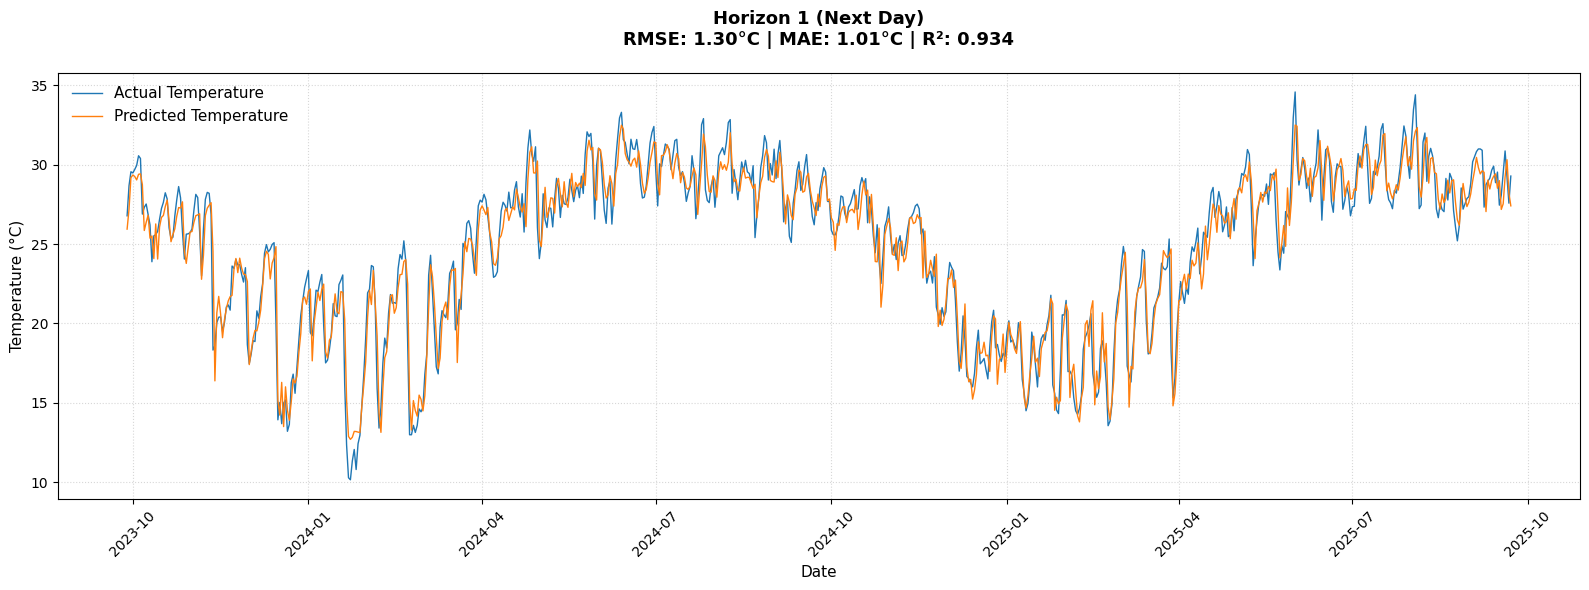

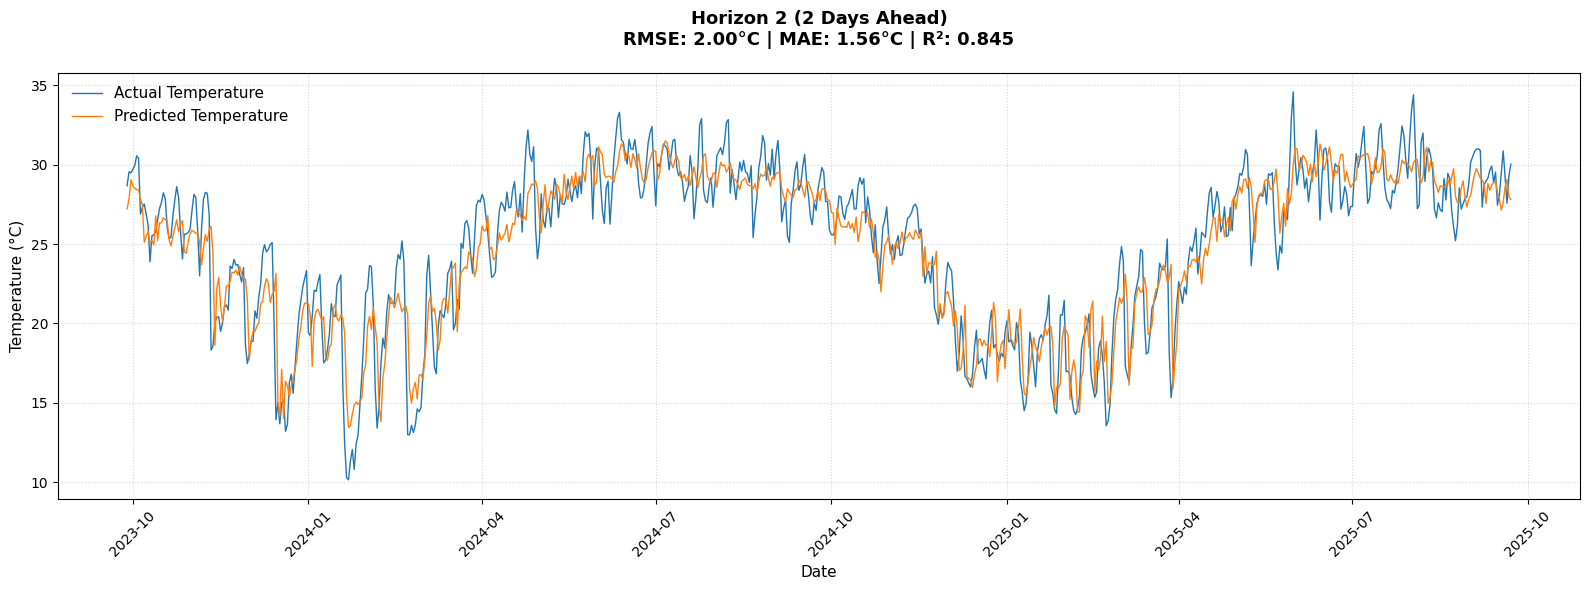

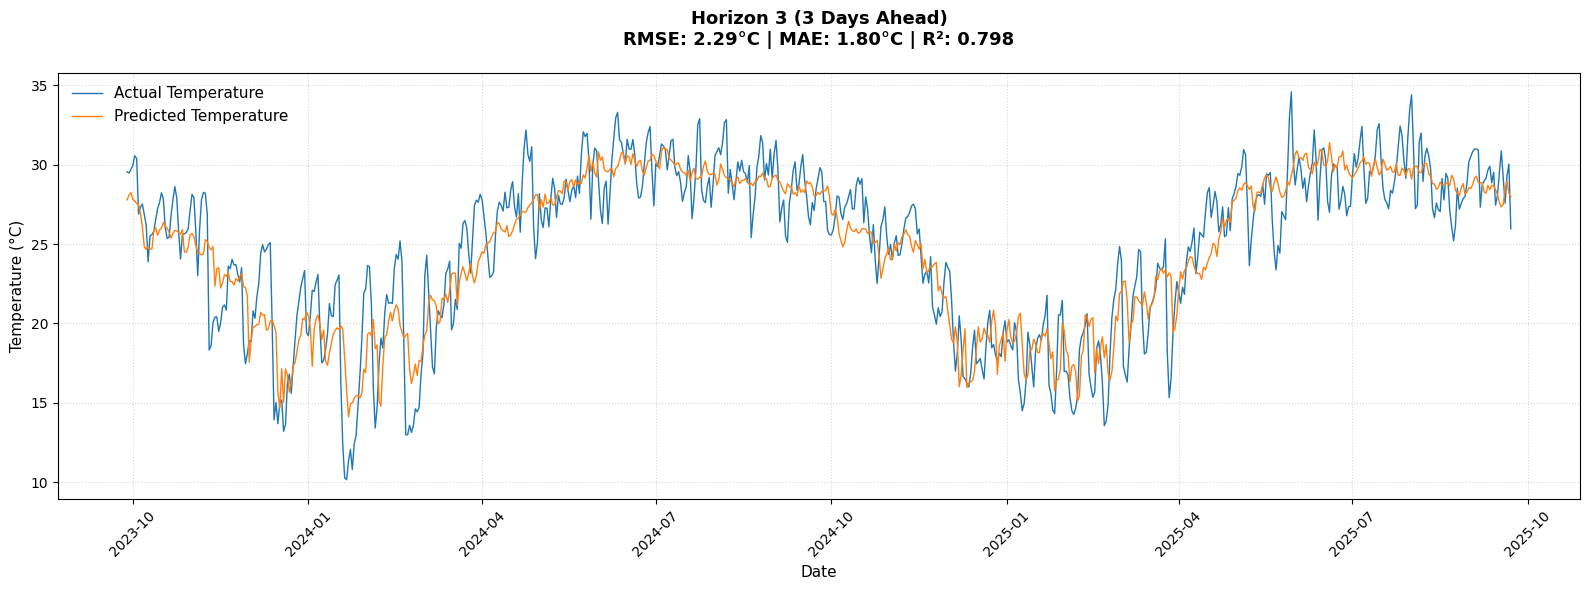

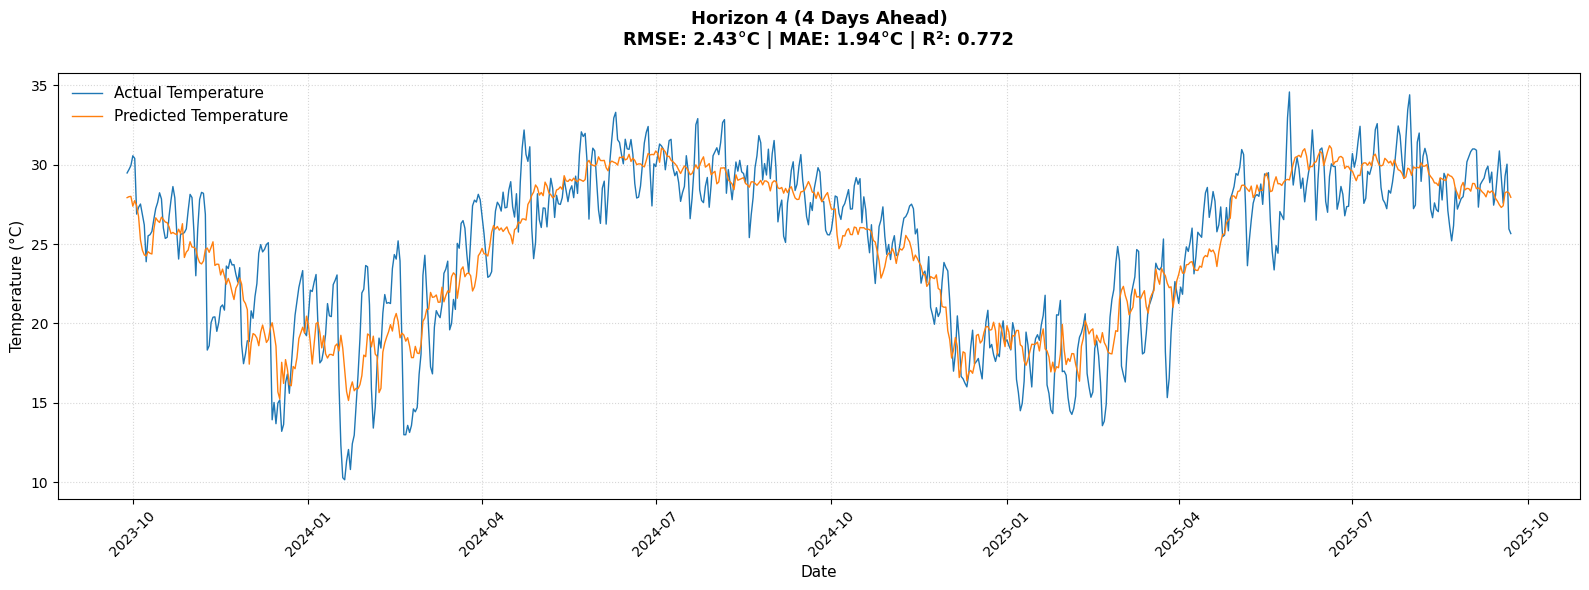

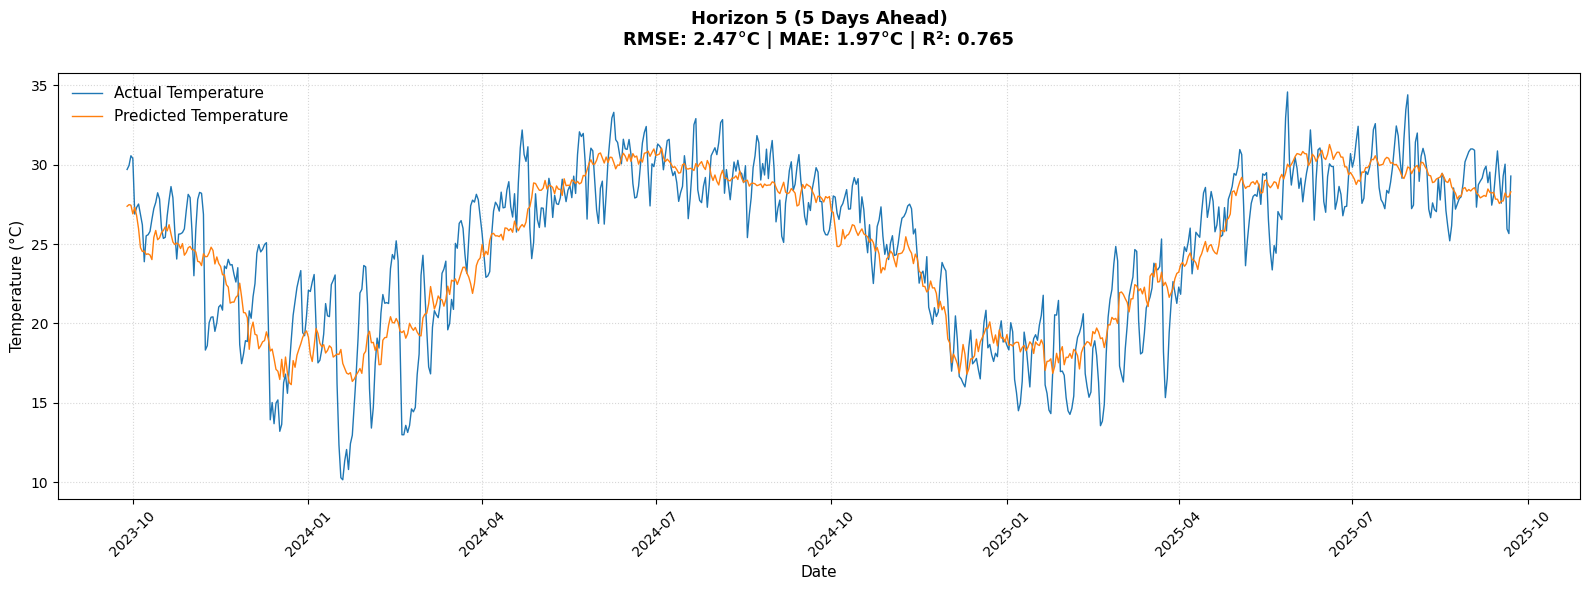

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_separate_horizons(y_test, y_pred_test, figsize=(16, 6)):
    """
    Vẽ 5 biểu đồ riêng biệt cho 5 horizons.
    Mỗi biểu đồ hiển thị dữ liệu thực (y_true) và dự đoán (y_pred)
    với màu và kiểu đường dễ phân biệt.
    """
    
    # Kiểm tra input
    assert y_test.shape[1] == 5, "y_test phải có 5 columns"
    assert y_pred_test.shape[1] == 5, "y_pred_test phải có 5 columns"
    assert len(y_test) == len(y_pred_test), "Số samples phải khớp"
    
    horizon_names = [
        'Horizon 1 (Next Day)', 
        'Horizon 2 (2 Days Ahead)', 
        'Horizon 3 (3 Days Ahead)', 
        'Horizon 4 (4 Days Ahead)', 
        'Horizon 5 (5 Days Ahead)'
    ]
    
    # Màu nhẹ cho Actual, màu đậm cho Predict
    true_color = "#1f77b4"   # Xanh dương dịu
    pred_color = "#ff7f0e"   # Cam dịu
    
    for i in range(5):
        plt.figure(figsize=figsize)
        
        y_true_horizon = y_test.iloc[:, i]
        y_pred_horizon = y_pred_test[:, i]
        dates = y_test.index
        
        # Metrics
        rmse = np.sqrt(np.mean((y_true_horizon - y_pred_horizon) ** 2))
        mae = np.mean(np.abs(y_true_horizon - y_pred_horizon))
        r2 = 1 - np.sum((y_true_horizon - y_pred_horizon) ** 2) / np.sum((y_true_horizon - np.mean(y_true_horizon)) ** 2)
        
        # --- Vẽ biểu đồ ---
        plt.plot(
            dates, y_true_horizon, 
            label='Actual Temperature', 
            color=true_color, 
            linewidth=1
        )
        
        plt.plot(
            dates, y_pred_horizon, 
            label='Predicted Temperature', 
            color=pred_color, 
            linewidth=1
        )
        
        # --- Tuỳ chỉnh ---
        plt.title(
            f'{horizon_names[i]}\nRMSE: {rmse:.2f}°C | MAE: {mae:.2f}°C | R²: {r2:.3f}',
            fontsize=13, fontweight='bold', pad=20
        )
        plt.ylabel('Temperature (°C)', fontsize=11)
        plt.xlabel('Date', fontsize=11)
        plt.legend(fontsize=11, frameon=False)
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


plot_separate_horizons(y_test, y_pred_test)


c:\Users\Ms Nhan\AppData\Local\Programs\Python\Python313\Lib\site-packages\clearml\utilities\plotlympl\mplexporter\exporter.py:101: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



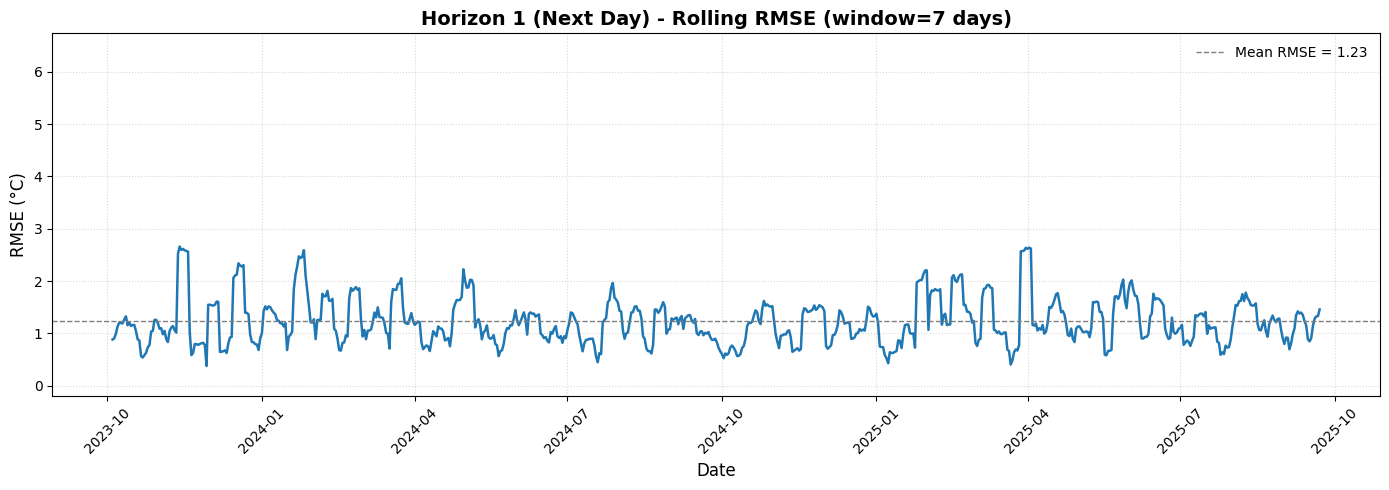

c:\Users\Ms Nhan\AppData\Local\Programs\Python\Python313\Lib\site-packages\clearml\utilities\plotlympl\mplexporter\exporter.py:101: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



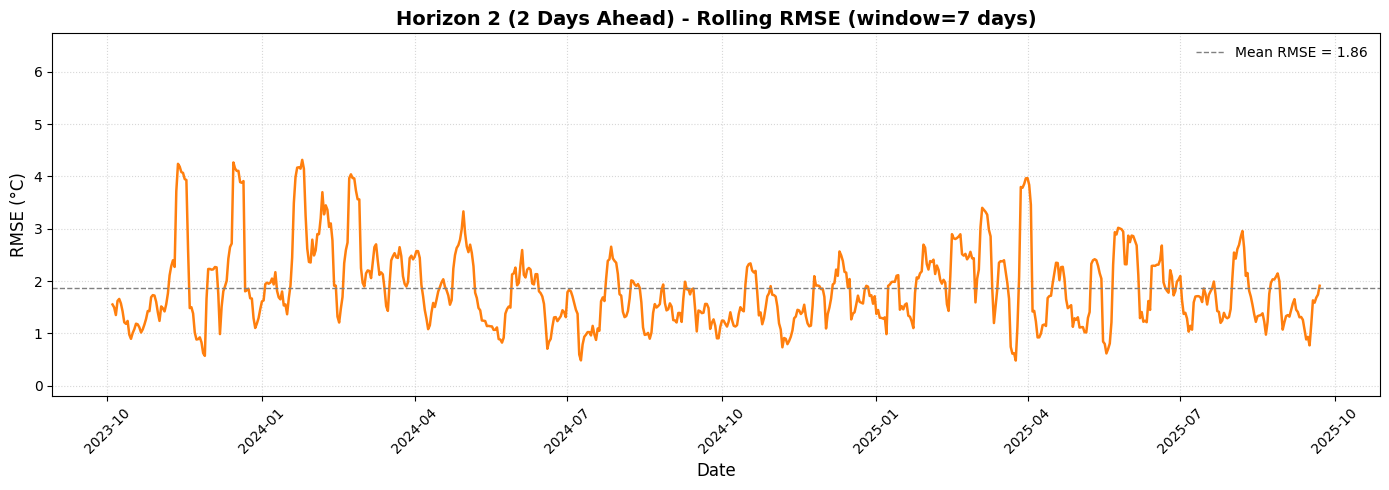

c:\Users\Ms Nhan\AppData\Local\Programs\Python\Python313\Lib\site-packages\clearml\utilities\plotlympl\mplexporter\exporter.py:101: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



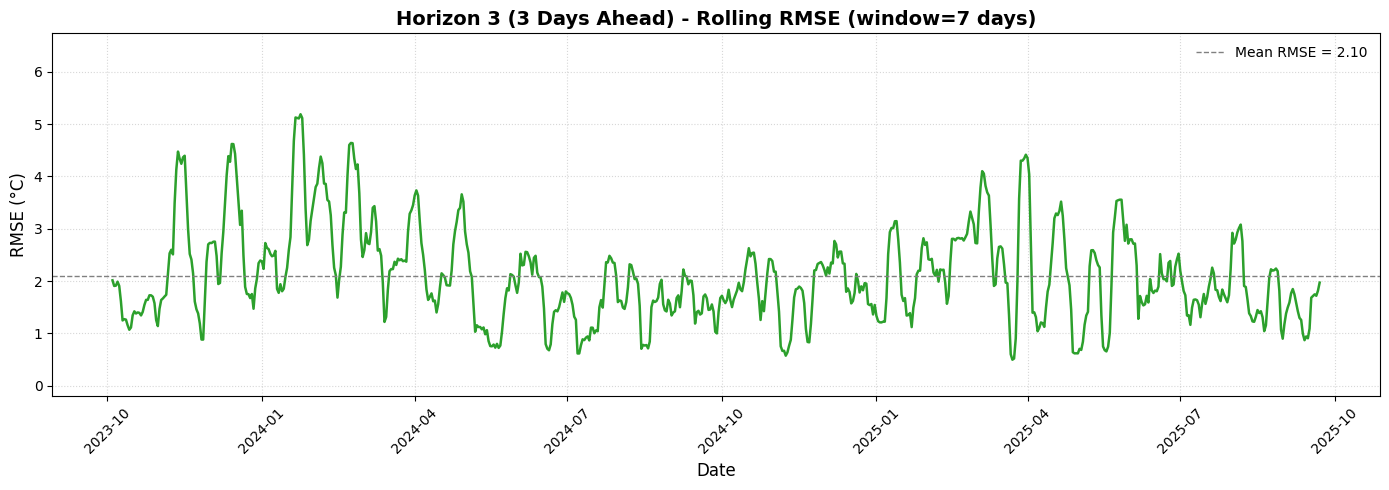

c:\Users\Ms Nhan\AppData\Local\Programs\Python\Python313\Lib\site-packages\clearml\utilities\plotlympl\mplexporter\exporter.py:101: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



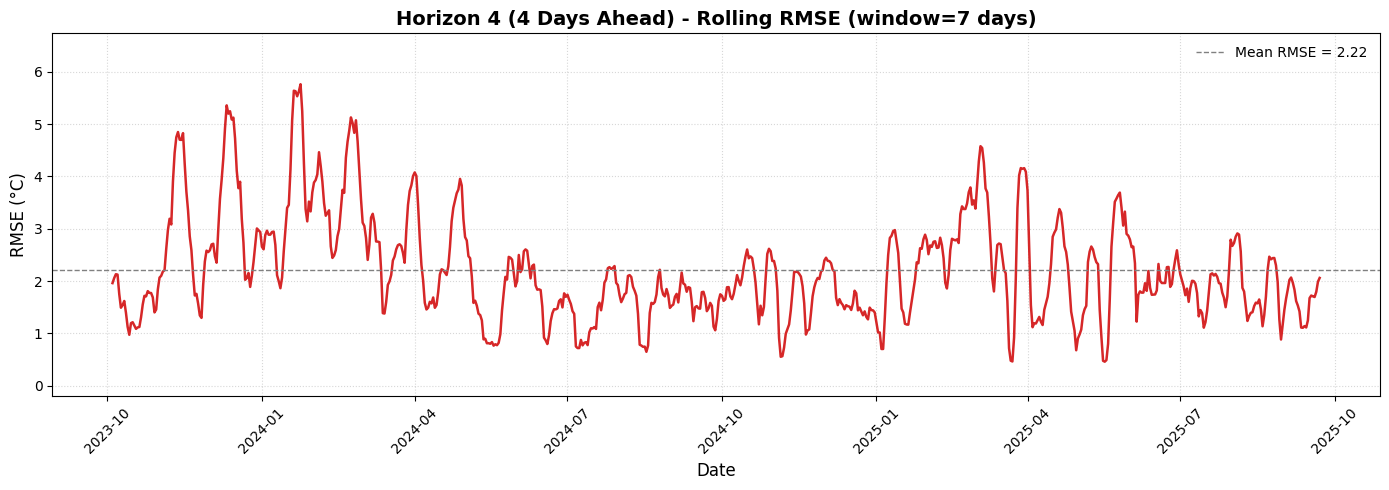

c:\Users\Ms Nhan\AppData\Local\Programs\Python\Python313\Lib\site-packages\clearml\utilities\plotlympl\mplexporter\exporter.py:101: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



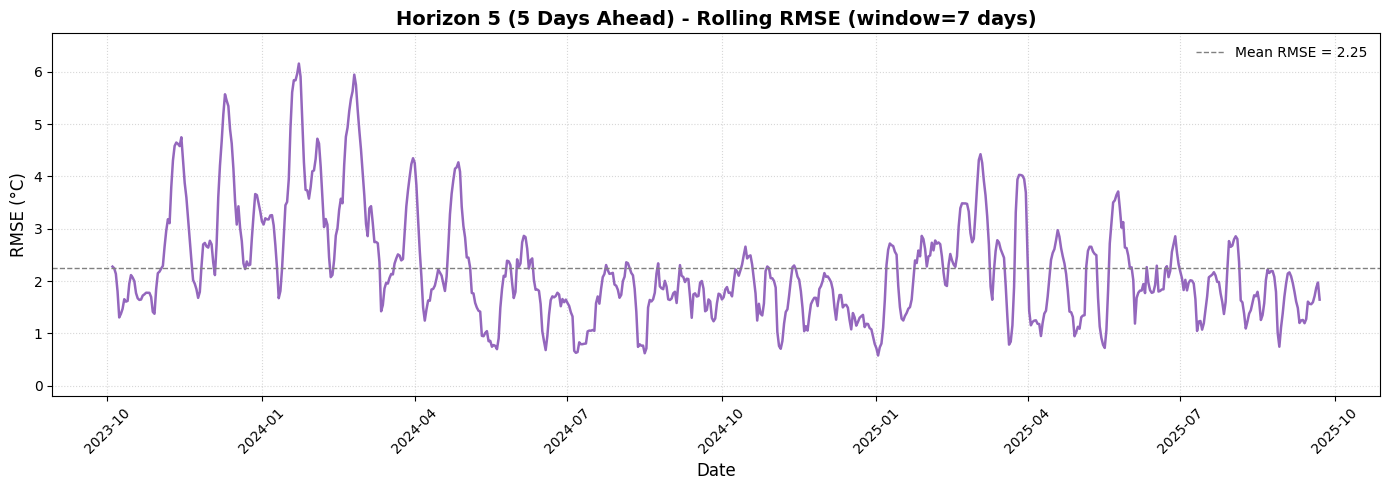

In [23]:
def plot_rmse_over_time(y_test, y_pred_test, window=7, figsize=(14, 5)):
    """
    Vẽ 5 biểu đồ riêng biệt cho RMSE theo thời gian (rolling window),
    với cùng đơn vị (cố định trục Y).
    """
    
    # Kiểm tra input
    assert y_test.shape[1] == 5, "y_test phải có 5 columns"
    assert y_pred_test.shape[1] == 5, "y_pred_test phải có 5 columns"
    assert len(y_test) == len(y_pred_test), "Số samples phải khớp"
    
    horizon_names = [
        'Horizon 1 (Next Day)', 
        'Horizon 2 (2 Days Ahead)', 
        'Horizon 3 (3 Days Ahead)', 
        'Horizon 4 (4 Days Ahead)', 
        'Horizon 5 (5 Days Ahead)'
    ]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    dates = y_test.index

    # Tính rolling RMSE cho tất cả horizons để tìm giới hạn trục Y chung
    all_rmse = []
    for i in range(5):
        y_true = y_test.iloc[:, i]
        y_pred = y_pred_test[:, i]
        rolling_rmse = np.sqrt(((y_true - y_pred)**2).rolling(window).mean())
        all_rmse.append(rolling_rmse)

    # Tính min/max chung cho toàn bộ 5 biểu đồ
    all_values = pd.concat(all_rmse)
    ymin, ymax = all_values.min(), all_values.max()
    margin = (ymax - ymin) * 0.1  # thêm khoảng trống 10%
    ymin -= margin
    ymax += margin

    # Vẽ từng biểu đồ
    for i in range(5):
        plt.figure(figsize=figsize)
        plt.plot(dates, all_rmse[i], color=colors[i], linewidth=1.8)
        
        mean_rmse = all_rmse[i].mean()
        plt.axhline(mean_rmse, color='gray', linestyle='--', linewidth=1,
                    label=f'Mean RMSE = {mean_rmse:.2f}')
        
        plt.title(f'{horizon_names[i]} - Rolling RMSE (window={window} days)', 
                  fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('RMSE (°C)', fontsize=12)
        plt.ylim(ymin, ymax)  # <-- cố định trục Y
        plt.legend(fontsize=10, frameon=False)
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_rmse_over_time(y_test, y_pred_test, window=7)


In [24]:
# === 3. Chạy Optuna cho Gradient Boosting ===
study_grad = optuna.create_study(
    direction='minimize',
    sampler=sampler
)
study_grad.optimize(objective, n_trials=50, show_progress_bar=True)

# === In kết quả tốt nhất  ===
print("Best parameters:", study_grad.best_trial.params)
print("Best R2 (from Optuna CV):", study_grad.best_value)


[I 2025-11-08 23:05:04,842] A new study created in memory with name: no-name-5d57aa5a-64b1-4645-9466-663a8440642a


NameError: name 'objective' is not defined

In [ ]:
# === 4 Log kết quả tổng hợp ===
task_grad.upload_artifact("Best Parameters", study_grad.best_trial.params)

# Fit lại mô hình với best params
best_params = study_grad.best_trial.params
best_base_model = LGBMRegressor(**best_params)
best_model_grad = MultiOutputRegressor(estimator=best_base_model, n_jobs=-1)
best_model_grad.fit(X_train, y_train)

# Predict
y_pred_test = best_model_grad.predict(X_test)
y_pred_train = best_model_grad.predict(X_train)

# Evaluate on validation
bestGrad_val_metrics = evaluate_multi_output(y_val, y_pred_val)
print("Best Model - Validation metrics (average):", bestGrad_val_metrics["average"])

# Evaluate on test
bestGrad_test_metrics = evaluate_multi_output(y_test, y_pred_test)
print("Best Model - Test metrics (average):", bestGrad_test_metrics["average"])

# Evaluate on train
bestGrad_train_metrics = evaluate_multi_output(y_train, y_pred_train)
print("Best Model - Train metrics (average):", bestGrad_train_metrics["average"])

ValueError: No trials are completed yet.

In [ ]:

# 5. Save model 
model_path = r'models/Top35_Not_tune_selecGB40_LGB_model.pkl' 
joblib.dump(model_grad, model_path)
print(f"no_feature_t_XGB_selec_gb1 model saved to {model_path}")

# 6. Log lên ClearML
test_avg_metrics = defGrad_test_metrics["average"]
train_avg_metrics = defGrad_train_metrics["average"]

logger_grad.report_scalar("Default Metrics", "RMSE_test_avg", test_avg_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Default Metrics", "R2_test_avg", test_avg_metrics["R2"], iteration=0)
logger_grad.report_scalar("Default Metrics", "MAPE_test_avg", test_avg_metrics["MAPE"], iteration=0)
logger_grad.report_scalar("Default Metrics", "RMSE_train_avg", train_avg_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Default Metrics", "R2_train_avg", train_avg_metrics["R2"], iteration=0)
logger_grad.report_scalar("Default Metrics", "MAPE_train_avg", train_avg_metrics["MAPE"], iteration=0)

task_grad.upload_artifact("Default Metrics Detailed", {
    "Test": defGrad_test_metrics,
    "Train": defGrad_train_metrics
})


no_feature_t_XGB_selec_gb1 model saved to models/Top35_Not_tune_selecGB40_LGB_model.pkl


True

In [ ]:
## B. Hyperparameter tuning cho LGB
def objective(trial):
    # === 1. booster trước, để dùng điều kiện ===
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])

    # === 2. Không gian hyperparameter cho LGBM ===
    params = {
        'boosting_type': boosting_type,
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.3),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_bin': trial.suggest_int('max_bin', 64, 512),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),

        # Fixed parameters cho LGBM
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    # --- Thêm các tham số riêng cho DART ---
    if boosting_type == 'dart':
        params['drop_rate'] = trial.suggest_float('drop_rate', 0.05, 0.5)
        params['skip_drop'] = trial.suggest_float('skip_drop', 0.3, 0.7)

    # === 3. TimeSeriesSplit CV===
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train_sel):
        X_tr, X_val = X_train_sel.iloc[train_idx], X_train_sel.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # === 4. Train model ===
        base_model = LGBMRegressor(**params)
        model = MultiOutputRegressor(estimator=base_model, n_jobs=-1)

        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)

        # Dùng evaluate_multi_output để tính RMSE trung bình
        metrics = evaluate_multi_output(y_val, y_pred_val)
        rmse_scores.append(metrics["average"]["RMSE"])

    mean_rmse = np.mean(rmse_scores)

    # === 5. Log kết quả lên ClearML ===
    logger_grad.report_scalar(
        title='Optuna Tuning - LGB',
        series='Trial Avg RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([params], index=[0])
    logger_grad.report_table(
        title=f"Trial {trial.number} Parameters",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    # === 6. Trả về RMSE trung bình để Optuna minimize ===
    return mean_rmse


In [ ]:
# # Try new objective with pruning
# def objective(trial):
#     # === 1. Định nghĩa không gian hyperparameter thông minh hơn ===
#     params = {

#         # Sử dụng log=True để tìm kiếm learning_rate hiệu quả hơn
#         'loss': trial.suggest_categorical('loss', ['squared_error', 'huber']),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1500), # Mở rộng khoảng một chút
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.05), # Chia nhỏ bước nhảy
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
#         'max_depth': trial.suggest_int('max_depth', 3, 8),
#         'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.2),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']), # Bỏ None để giảm độ phức tạp
#         'tol': 1e-4,
#         # 'ccp_alpha': 0.0,
#         'random_state': 42
#     }

#     # Chỉ gợi ý 'alpha' khi 'loss' là 'huber'
#     if params['loss'] == 'huber':
#         params['alpha'] = trial.suggest_float('alpha', 0.8, 0.99)

#     # === 2. TimeSeriesSplit CV với PRUNING (CẮT TỈA) ===
#     cv = TimeSeriesSplit(n_splits=5)
#     rmse_scores = []

#     # Dùng enumerate để lấy step cho pruning
#     for step, (train_idx, val_idx) in enumerate(cv.split(X_train)):
#         X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

#         # === 3. Train model ===
#         model = GradientBoostingRegressor(**params)
#         model.fit(X_tr, y_tr)
#         y_pred_val = model.predict(X_val)

#         metrics = evaluate(y_val, y_pred_val)
#         rmse_score = metrics['RMSE']
#         rmse_scores.append(rmse_score)
        
#         # === BƯỚC CẢI TIẾN QUAN TRỌNG NHẤT: PRUNING ===
#         # 1. Báo cáo kết quả trung gian của fold này cho Optuna
#         trial.report(rmse_score, step)

#         # 2. Kiểm tra xem trial này có nên bị dừng sớm không
#         if trial.should_prune():
#             # Ném ra ngoại lệ để dừng trial này và chuyển sang trial tiếp theo
#             raise optuna.exceptions.TrialPruned()

#     mean_rmse = np.mean(rmse_scores)

#     # === 4. Log kết quả lên ClearML (Giữ nguyên) ===
#     logger_grad.report_scalar(
#         title='Optuna Tuning - GradientBoosting', series='Trial RMSE',
#         value=mean_rmse, iteration=trial.number)
    
#     params_table = pd.DataFrame([{"trial": trial.number, "mean_rmse": mean_rmse, **trial.params}])
#     logger_grad.report_table(
#         title="All Trials Summary", series="params_summary",
#         iteration=trial.number, table_plot=params_table)

#     # === 5. Trả về RMSE trung bình để Optuna minimize ===
#     return mean_rmse

In [ ]:
# def objective_r2(trial):
#     # === 1. Định nghĩa không gian hyperparameter (Giữ nguyên hoặc tinh chỉnh nếu muốn) ===
#     # Sử dụng không gian tìm kiếm đã được tinh chỉnh ở lần trước
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 31, 256),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'min_child_samples': trial.suggest_int('min_child_samples', 10, 80),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True),
#         'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),
#         'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
#         'random_state': 42,
#         'n_jobs': -1
#     }


#     # === 2. TimeSeriesSplit CV ===
#     cv = TimeSeriesSplit(n_splits=5)
#     r2_scores = [] # THAY ĐỔI 2: Đổi tên list để lưu R-squared scores

#     for train_idx, val_idx in cv.split(X_train_sel):
#         X_tr, X_val = X_train_sel.iloc[train_idx], X_train_sel.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

#         # === 3. Train model ===
#         model = LGBMRegressor(**params)
#         model.fit(X_tr, y_tr)
#         y_pred_val = model.predict(X_val)

#         metrics = evaluate(y_val, y_pred_val)
#         r2_score = metrics['R2']  # THAY ĐỔI 3: Lấy R-squared thay vì RMSE
#         r2_scores.append(r2_score)

#     mean_r2 = np.mean(r2_scores) # THAY ĐỔI 4: Tính trung bình R-squared

#     # === 4. Log kết quả lên ClearML (Cập nhật để log R-squared) ===
#     logger_grad.report_scalar(
#         title='Optuna Tuning - R-squared', # Cập nhật title
#         series='Trial R2',               # Cập nhật series
#         value=mean_r2,                   # Log giá trị R-squared
#         iteration=trial.number
#     )

#     params_summary = {"trial": trial.number, "mean_r2": mean_r2, **trial.params}
#     logger_grad.report_table(
#         title="All Trials Summary (R2)", series="params_summary_r2",
#         iteration=trial.number, table_plot=pd.DataFrame([params_summary])
#     )

#     # === 5. Trả về R-squared trung bình để Optuna MAXIMIZE ===
#     return mean_r2

In [ ]:
# # === 3. Chạy Optuna study cho Gradient Boosting ===
# #maximize R-squared
# study_grad = optuna.create_study(
#     direction='maximize',  # THAY ĐỔI: Tối đa hóa R-squared
#     sampler=sampler
# )

# # Tiến hành tối ưu
# study_grad.optimize(objective_r2, n_trials=50, show_progress_bar=True)

# # === 4. In kết quả tốt nhất ===
# print("Best parameters:", study_grad.best_trial.params)
# print("Best R-squared:", study_grad.best_value)

In [ ]:


# 6 Log lên ClearML
val_avg_metrics = bestGrad_val_metrics["average"]
test_avg_metrics = bestGrad_test_metrics["average"]
logger_grad.report_scalar("Best Metrics", "RMSE_val_avg", val_avg_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "R2_val_avg", val_avg_metrics["R2"], iteration=0)
logger_grad.report_scalar("Best Metrics", "MAPE_val_avg", val_avg_metrics["MAPE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "RMSE_test_avg", test_avg_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "R2_test_avg", test_avg_metrics["R2"], iteration=0)
logger_grad.report_scalar("Best Metrics", "MAPE_test_avg", test_avg_metrics["MAPE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "RMSE_train_avg", train_avg_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "R2_train_avg", train_avg_metrics["R2"], iteration=0)
logger_grad.report_scalar("Best Metrics", "MAPE_train_avg", train_avg_metrics["MAPE"], iteration=0)


task_grad.upload_artifact("Best Metrics Detailed", {
    "Validation": bestGrad_val_metrics,
    "Test": bestGrad_test_metrics,
    "Train": bestGrad_train_metrics
})

# Save & upload model
model_path = r'models/Tuning_lgb_model.pkl' 
joblib.dump(best_model_grad, model_path)
print(f"lgb model saved to {model_path}")
task_grad.upload_artifact("Best Model", model_path)

NameError: name 'bestGrad_val_metrics' is not defined

In [ ]:
# === Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(7, 4))
plt.plot([t.value for t in study_grad.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_grad.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(study_grad.trials)
)
plt.close(fig3)


In [ ]:
vis.plot_parallel_coordinate(study_grad)

[W 2025-11-08 16:00:10,350] Your study does not have any completed trials.


In [ ]:
vis.plot_slice(study=study_grad)

[W 2025-11-08 16:00:14,098] Your study does not have any completed trials.


In [ ]:
vis.plot_param_importances(study=study_grad)

[W 2025-11-08 16:00:18,083] Study instance does not contain completed trials.


In [ ]:
task_grad.close()